In [1]:
from __future__ import division, print_function

import sys

In [2]:
sys.path.append('/home/jovyan/pysparknlp-1.0.0/')

In [3]:
import matplotlib.pyplot as plt
import nltk
import pyspark
import spacy
import sparknlp.annotators as sparknlp
import wordcloud

%matplotlib inline

In [4]:
spark = pyspark.sql.SparkSession.builder \
    .master('local[4]') \
    .appName('notebook') \
    .config('spark.jars', 'pysparknlp-1.0.0/lib/sparknlp.jar') \
    .config('spark.jars.packages', 'com.databricks:spark-xml_2.11:0.4.1') \
    .getOrCreate()

In [5]:
nlp = spacy.load('en')

In [6]:
medline_df = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rowTag", "Article") \
    .load("demo-data/medline17n0001.xml") \

In [7]:
medline_df.count()

30000

In [8]:
medline_df.printSchema()

root
 |-- Abstract: struct (nullable = true)
 |    |-- AbstractText: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _Label: string (nullable = true)
 |    |    |    |-- _NlmCategory: string (nullable = true)
 |    |    |    |-- _VALUE: string (nullable = true)
 |-- ArticleTitle: string (nullable = true)
 |-- AuthorList: struct (nullable = true)
 |    |-- Author: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- AffiliationInfo: struct (nullable = true)
 |    |    |    |    |-- Affiliation: string (nullable = true)
 |    |    |    |-- CollectiveName: string (nullable = true)
 |    |    |    |-- ForeName: string (nullable = true)
 |    |    |    |-- Initials: string (nullable = true)
 |    |    |    |-- LastName: string (nullable = true)
 |    |    |    |-- Suffix: string (nullable = true)
 |    |    |    |-- _ValidYN: string (nullable = true)
 |    |-- _CompleteYN: string (nullable = true)
 

In [9]:
text_concat_UDF = pyspark.sql.functions.udf(lambda arr: '\n\n'.join(arr) if arr else None)

In [10]:
texts_df = medline_df \
    .select(
        text_concat_UDF(medline_df["Abstract.AbstractText._VALUE"]).alias("text"),
        medline_df["ArticleTitle"].alias("title")
    ).distinct()    

In [11]:
texts_df.count()

29932

In [12]:
texts_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)



In [13]:
texts_df.show()

+--------------------+--------------------+
|                text|               title|
+--------------------+--------------------+
|                null|Formation of fert...|
|Human glucose 6-p...|Purification of h...|
|The interactions ...|On the interactio...|
|                null|If you like varie...|
|One inbred mouse ...|Molecular nature ...|
|Peptic and chymot...|The amino acid se...|
|The kinetic mecha...|Investigations on...|
|                null|Patient classific...|
|Microcalorimetry ...|Microcalorimetric...|
|The chromatograph...|Chromatographic b...|
|The metabolism of...|Metabolism of del...|
|The management of...|[Past and present...|
|                null|[Periarteritis no...|
|Fast reaction tec...|Mechanistic studi...|
|The nature of mol...|Intermolecular fo...|
|                null|[Clinical charact...|
|A method of isola...|Isolation, chemic...|
|1. Techniques and...|Kinetic studies o...|
|Lipids are separa...|Separation of pes...|
|                null|Proceeding

In [14]:
cleaned_df = texts_df \
    .filter("text IS NOT NULL") \
    .filter("title IS NOT NULL") \
    .withColumn("length", pyspark.sql.functions.length(texts_df["text"])) \
    .persist()

In [15]:
cleaned_df.count()

15377

In [16]:
cleaned_df.show()

+--------------------+--------------------+------+
|                text|               title|length|
+--------------------+--------------------+------+
|Human glucose 6-p...|Purification of h...|   511|
|The interactions ...|On the interactio...|  1131|
|One inbred mouse ...|Molecular nature ...|  1200|
|Peptic and chymot...|The amino acid se...|  1025|
|The kinetic mecha...|Investigations on...|   651|
|Microcalorimetry ...|Microcalorimetric...|   661|
|The chromatograph...|Chromatographic b...|   579|
|The metabolism of...|Metabolism of del...|   871|
|The management of...|[Past and present...|   598|
|Fast reaction tec...|Mechanistic studi...|   830|
|The nature of mol...|Intermolecular fo...|   751|
|A method of isola...|Isolation, chemic...|  1228|
|1. Techniques and...|Kinetic studies o...|  2539|
|Lipids are separa...|Separation of pes...|   504|
|I report further ...|New techniques fo...|  2058|
|A DNA kinase has ...|A deoxyribonuclei...|   752|
|A simple and accu...|Quantitat

In [24]:
sample_df = cleaned_df.limit(1000)

In [25]:
document_assembler = sparknlp.DocumentAssembler(inputCol='text')
    
tokenizer = sparknlp.RegexTokenizer(inputCols=['document'], outputCol='token')

In [26]:
tokenizer_pipeline = pyspark.ml.Pipeline(stages=[document_assembler, tokenizer]).fit(sample_df)

In [27]:
sparknlp_time = %timeit -o sparknlp_num_tokens = tokenizer_pipeline \
    .transform(sample_df) \
    .selectExpr('sum(size(token)) AS num_tokens') \
    .first()['num_tokens']

469 ms ± 9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
'{:0.4} ms/doc'.format(1000 * sparknlp_time.average / cleaned_df.count())

'0.03047 ms/doc'

In [29]:
sample_texts = sample_df.select('text').rdd.map(lambda r: r[0]).collect()

In [30]:
spacy_time = %timeit -o spacy_num_tokens = sum(\
    len(doc) for doc in nlp.pipe(sample_texts, tag=False, parse=False, entity=False, n_threads=4))

1.26 s ± 5.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
'{:0.4} ms/doc'.format(1000 * spacy_time.average / cleaned_df.count())

'0.08175 ms/doc'

In [32]:
nltk_time = %timeit -o nltk_num_tokens = sum(\
    len(nltk.tokenize.word_tokenize(text)) for text in sample_texts)

1.84 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
'{:0.4} ms/doc'.format(1000 * nltk_time.average / cleaned_df.count())

'0.1194 ms/doc'

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml import feature as spark_ft
from pyspark.ml import clustering as spark_cl

In [35]:
document_assembler = sparknlp.DocumentAssembler(inputCol='text', outputCol='document')
    
tokenizer = sparknlp.RegexTokenizer(inputCols=['document'], outputCol='token')

stemmer = sparknlp.Stemmer(inputCols=['token'], outputCol='stem')

normalizer = sparknlp.Normalizer(inputCols=['stem'], outputCol='ntoken')

nlp_pipeline = Pipeline(stages=[document_assembler, tokenizer, stemmer, normalizer])

In [36]:
token_extractor = spark_ft.SQLTransformer(statement='''
SELECT text, title, length, collect_list(ntoken) AS ntokens
FROM (
    SELECT text, title, length, ntoken_anno.metadata['token'] AS ntoken
    FROM (
        SELECT text, title, length, explode(ntoken) AS ntoken_anno
        FROM __THIS__
    )
)
GROUP BY text, title, length
''')

stopWords = spark_ft.StopWordsRemover.loadDefaultStopWords('english')
sw_remover = spark_ft.StopWordsRemover(inputCol='ntokens', outputCol='clean_tokens', stopWords=stopWords)

tf = spark_ft.CountVectorizer(vocabSize=500, inputCol='clean_tokens', outputCol='tf')

idf = spark_ft.IDF(minDocFreq=5, inputCol='tf', outputCol='idf')

feature_pipeline = Pipeline(stages=[token_extractor, sw_remover, tf, idf])

In [37]:
lda = spark_cl.LDA(k=10, featuresCol='idf', seed=123)

pipeline = Pipeline(stages=[nlp_pipeline, feature_pipeline, lda])

In [38]:
pipeline_model = pipeline.fit(cleaned_df)

In [39]:
lda_model = pipeline_model.stages[-1]

In [40]:
lda_model.describeTopics(maxTermsPerTopic=100).show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[246, 274, 478, 1...|[0.02941789522805...|
|    1|[209, 182, 38, 43...|[0.02326860801737...|
|    2|[34, 1, 6, 118, 5...|[0.02442429621273...|
|    3|[9, 168, 146, 220...|[0.04464859409488...|
|    4|[51, 151, 226, 27...|[0.03588340284310...|
|    5|[14, 43, 66, 4, 4...|[0.02428532146781...|
|    6|[275, 241, 412, 3...|[0.02344429058192...|
|    7|[211, 186, 1, 294...|[0.01782569628188...|
|    8|[6, 2, 78, 22, 92...|[0.03017898879662...|
|    9|[102, 164, 137, 2...|[0.02119330660423...|
+-----+--------------------+--------------------+



In [41]:
tf_model = pipeline_model.stages[1].stages[2]

In [42]:
topic_vocabs = {}

for row in lda_model.describeTopics(maxTermsPerTopic=200).collect():
    ((_, topic), (_, terms), (_, weights)) = row.asDict().items()
    topic_vocabs[topic] = [(tf_model.vocabulary[term], wt) for term, wt in zip(terms, weights)]

topic_vocabs

{0: [('gastric', 0.02941789522805611),
  ('secret', 0.021730125629893623),
  ('insulin', 0.01988994578048492),
  ('ca', 0.019827066785232075),
  ('lipid', 0.01849340368629974),
  ('acid', 0.016881341440489746),
  ('synthesi', 0.01596190556345138),
  ('fatti', 0.015914535558602668),
  ('chronic', 0.014801206791126809),
  ('nm', 0.013724184011044773),
  ('releas', 0.013032226380549043),
  ('stimul', 0.011380981201564321),
  ('protein', 0.011062741707161547),
  ('tyrosin', 0.00992958928935468),
  ('typ', 0.009688725840785027),
  ('effect', 0.008464257493152763),
  ('ar', 0.008090773274869744),
  ('mai', 0.007989976707806804),
  ('increas', 0.007614213361799219),
  ('infect', 0.007438246009553321),
  ('hormon', 0.007374936048473404),
  ('incorpor', 0.007155500524368355),
  ('absorpt', 0.006951601621973024),
  ('action', 0.006942040486384785),
  ('interact', 0.006861695577724666),
  ('inhibit', 0.00665359272792059),
  ('role', 0.0064442586963389375),
  ('activ', 0.0061009611890757145),
  ('

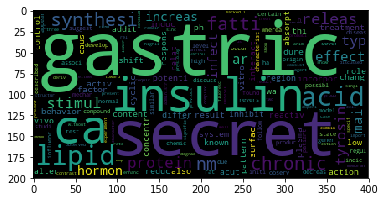

In [43]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[0]))

plt.imshow(wc)
plt.show()

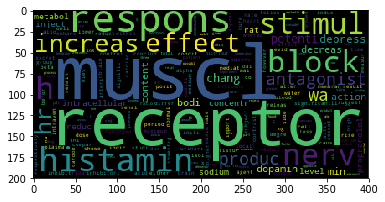

In [44]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[1]))

plt.imshow(wc)
plt.show()

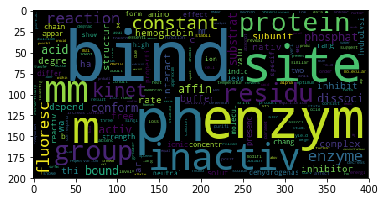

In [45]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[2]))

plt.imshow(wc)
plt.show()

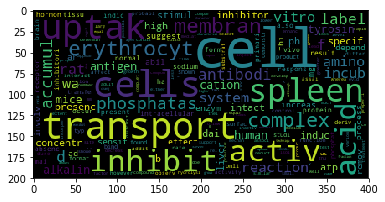

In [46]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[3]))

plt.imshow(wc)
plt.show()

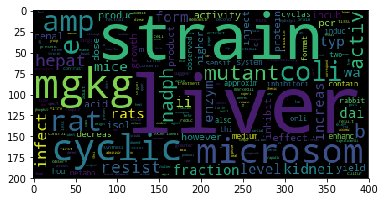

In [47]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[4]))

plt.imshow(wc)
plt.show()

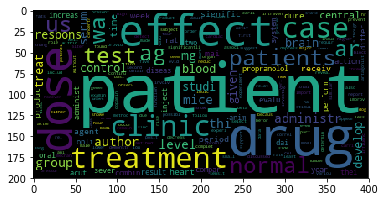

In [48]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[5]))

plt.imshow(wc)
plt.show()

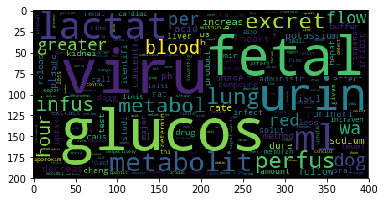

In [49]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[6]))

plt.imshow(wc)
plt.show()

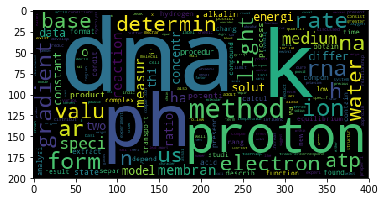

In [50]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[7]))

plt.imshow(wc)
plt.show()

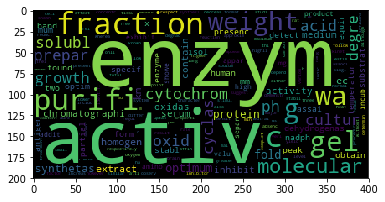

In [51]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[8]))

plt.imshow(wc)
plt.show()

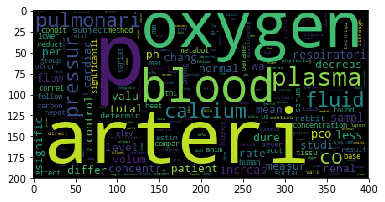

In [52]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[9]))

plt.imshow(wc)
plt.show()